
### 시작


In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
!pip install tensorflow
!pip install tensorflow-gpu
!pip install tensorflow-determinism

In [4]:
!pip install -q git+https://github.com/tensorflow/docs

In [0]:
#import tensorflow_docs as tfdocs
#import tensorflow_docs.modeling
#import tensorflow_docs.plots

In [0]:
# Import libraries
import numpy as np
import pandas as pd
#import seaborn as sns
import matplotlib.pyplot as plt
#import matplotlib as mpl
#from scipy import stats
#import statsmodels.api as sm
import warnings
from datetime import datetime
warnings.filterwarnings('ignore')
plt.style.use('seaborn-poster')
#from tqdm import tqdm
import random
import tensorflow as tf

from pathlib import Path
import os
import time
import collections
#import tensorflow_addons as tfa
#from sklearn.ensemble import RandomForestRegressor
#from sklearn.datasets import make_regression
#from sklearn.metrics import mean_squared_error

import lightgbm as lgb
import xgboost as xgb



In [7]:
# 작업 환경 변경 
folder = "dacon"
project_dir = "temperature"
data_folder = "data"

base_path = Path("/content/drive/My Drive/")
project_path = base_path / folder / project_dir
data_path = base_path / folder / data_folder / project_dir
os.chdir(project_path)
print(f"현재 디렉토리 위치: {os.getcwd()}")

현재 디렉토리 위치: /content/drive/My Drive/dacon/temperature


In [0]:
# randomseed 고정 
SEED = 202004
os.environ['TF_DETERMINISTIC_OPS'] = '1'
os.environ['PYTHONHASHSEED']=str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [9]:
# tf 버전 확인, gpu 리스트
print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))

2.1.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### 파일읽기

In [0]:
df_33 = pd.read_csv(os.path.join(data_path, 'train.csv'))
df_80 = pd.read_csv(os.path.join(data_path, 'test.csv'))

In [11]:
df_33.shape, df_80.shape

((4752, 60), (11520, 41))

In [0]:
# null값인 컬럼 삭제
del df_33['X14'], df_33['X16'], df_33['X19']
del df_80['X14'], df_80['X16'], df_80['X19'] 

In [13]:
df_33.shape, df_80.shape

((4752, 57), (11520, 38))

In [0]:
n = 4320

In [0]:
df_30 = df_33.iloc[:n].copy()
df_3 = df_33.iloc[n:].copy()

## 전처리

In [0]:
feat_time = ['time_m_sin', 'time_m_cos', 'time_h_sin', 'time_h_cos', 'time_diff', 'time_diff_2']
feat_temp = ['X00', 'X07', 'X28', 'X31', 'X32']
feat_air_press = ['X01', 'X06', 'X22', 'X27', 'X29']
feat_wind_speed = ['X02', 'X03', 'X18', 'X24', 'X26']
feat_rainfall = ['X04', 'X10', 'X21', 'X36', 'X39']
feat_sea_press = ['X05', 'X08', 'X09', 'X23', 'X33']
feat_insol = ['X11',  'X34']#'X14', 'X16', 'X19',
feat_humid = ['X12', 'X20', 'X30', 'X37', 'X38']
feat_dir_wind = ['X13', 'X15', 'X17', 'X25', 'X35']

feat_x = ['X00', 'X01', 'X02', 'X03', 'X04', 'X05', 'X06', 'X07', 'X08', 'X09', 
          'X10', 'X11', 'X12', 'X13', 'X15', 'X17', 'X18',  
          'X20', 'X21', 'X22', 'X23', 'X24', 'X25', 'X26', 'X27', 'X28', 'X29', 
          'X30', 'X31', 'X32', 'X33', 'X34', 'X35', 'X36', 'X37', 'X38', 'X39'] #'X14', 'X16', 'X19',

feat_x_t = feat_x + feat_time 

In [0]:
train_33 = df_33.copy()
test =  df_80.loc[:, feat_x].copy()

### time data

In [0]:
min_in_day = 24*6
hour_in_day = 24

feat_temp = ['X00', 'X07', 'X28', 'X31', 'X32']
diff = np.mean(train_33.loc[:n, feat_temp], axis=1) - np.mean(train_33.loc[:n, ['Y15', 'Y16', 'Y09']], axis=1)
diff_144= {i:diff[i::144].mean() for i in range(144)}

In [0]:
def time_data(frame):
    minute = pd.Series((frame.index%144).astype(int))
    hour= pd.Series((frame.index%144/6).astype(int))
    minute_sin = np.sin(np.pi*minute/min_in_day) 
    minute_cos = np.cos(np.pi*minute/min_in_day)
    hour_sin  = np.sin(np.pi*hour/hour_in_day)
    hour_cos  = np.cos(np.pi*hour/hour_in_day)
    tmp = (frame.index%144).astype(int).map(diff_144)
    return minute_sin, minute_cos, hour_sin, hour_cos, tmp, tmp-frame['X39']/5

In [20]:
train_33.shape, test.shape

((4752, 57), (11520, 37))

In [0]:
train_33['time_m_sin'], train_33['time_m_cos'], train_33['time_h_sin'], train_33['time_h_cos'], train_33['time_diff'], train_33['time_diff_2']  = time_data(train_33)
test['time_m_sin'], test['time_m_cos'], test['time_h_sin'], test['time_h_cos'], test['time_diff'], test['time_diff_2'] = time_data(test)

In [0]:
train_30 = train_33.iloc[:n].copy()
train_3 = train_33.iloc[n:].copy()

In [23]:
train_33.shape, train_30.shape, train_3.shape, test.shape

((4752, 63), (4320, 63), (432, 63), (11520, 43))

In [24]:
train_33

,id,X00,X01,X02,X03,X04,X05,X06,X07,X08,X09,X10,X11,X12,X13,X15,X17,X18,X20,X21,X22,X23,X24,X25,X26,X27,X28,X29,X30,X31,X32,X33,X34,X35,X36,X37,X38,X39,Y00,Y01,Y02,Y03,Y04,Y05,Y06,Y07,Y08,Y09,Y10,Y11,Y12,Y13,Y14,Y15,Y16,Y17,Y18,time_m_sin,time_m_cos,time_h_sin,time_h_cos,time_diff,time_diff_2
0,0,9.7,988.8,1.2,0.6,0.0,1009.3,989.6,12.2,1009.9,1009.8,0.0,0.00,82.4,71.3,101.1,56.1,0.3,91.0,0.0,1002.5,1009.8,1.1,2.3,0.5,1008.7,12.3,1001.6,69.1,8.2,10.7,1010.1,0.00,256.4,0.0,77.2,62.6,0.0,12.5,11.5,11.0,20.0,20.0,10.5,10.0,10.5,10.0,7.0,7.5,7.0,9.0,10.0,9.5,9.0,8.0,9.0,NaN,0.000000,1.000000,0.000000,1.000000,1.361556,1.361556
1,1,9.3,988.9,1.7,1.9,0.0,1009.3,989.6,12.1,1010.0,1009.9,0.0,0.00,81.2,121.8,165.3,0.0,0.4,91.9,0.0,1002.5,1009.9,0.0,0.0,0.0,1008.7,12.1,1001.7,70.3,8.3,10.3,1010.1,0.00,215.4,0.0,77.3,63.5,0.0,12.5,11.0,11.0,20.0,20.0,10.0,9.5,10.0,9.5,6.5,7.5,7.0,8.5,10.0,9.5,9.0,7.5,9.0,NaN,0.021815,0.999762,0.000000,1.000000,1.399556,1.399556
2,2,9.4,989.0,1.1,2.3,0.0,1009.2,989.7,12.1,1010.1,1010.1,0.0,0.00,86.1,232.0,144.0,0.0,0.6,93.3,0.0,1002.4,1009.8,0.0,0.0,0.0,1008.6,12.1,1001.6,71.5,8.0,9.7,1010.0,0.00,235.2,0.0,77.3,63.9,0.0,12.0,11.0,11.0,19.5,19.5,10.0,9.0,10.0,9.0,6.5,7.5,6.5,8.0,9.5,9.5,8.5,7.5,8.5,NaN,0.043619,0.999048,0.000000,1.000000,1.446667,1.446667
3,3,9.4,988.9,1.5,0.7,0.0,1009.2,989.6,12.0,1010.0,1010.0,0.0,0.00,87.7,0.0,115.9,294.1,0.1,93.4,0.0,1002.4,1009.7,0.0,0.0,0.2,1008.7,12.1,1001.5,73.2,7.7,9.4,1010.1,0.00,214.0,0.0,77.5,64.5,0.0,12.0,11.0,11.0,19.5,19.5,9.5,9.0,9.5,9.0,6.0,7.0,6.0,8.0,9.5,9.0,8.5,7.5,8.5,NaN,0.065403,0.997859,0.000000,1.000000,1.465111,1.465111
4,4,9.2,988.9,0.8,1.7,0.0,1009.2,989.7,12.0,1010.1,1010.0,0.0,0.00,88.9,0.0,124.7,0.0,0.0,94.1,0.0,1002.4,1009.7,0.0,0.0,0.0,1008.7,12.0,1001.5,74.3,7.4,9.4,1010.1,0.00,174.9,0.0,78.0,65.0,0.0,12.0,10.5,10.5,19.0,19.5,9.5,8.5,9.5,8.5,6.0,7.0,6.0,7.5,9.5,9.0,8.5,7.5,8.5,NaN,0.087156,0.996195,0.000000,1.000000,1.515556,1.515556
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4747,4747,19.9,987.6,0.9,0.8,0.0,1006.9,987.7,21.7,1007.5,1007.4,2.5,23.88,95.3,333.1,274.9,275.5,0.9,89.7,10.5,1000.4,1007.5,0.0,0.0,1.2,1006.0,23.8,999.4,89.9,17.7,19.1,1007.5,22.16,218.6,0.0,82.3,58.6,0.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21.5,0.108867,-0.994056,0.130526,-0.991445,1.316667,1.216667
4748,4748,19.9,987.6,0.5,0.7,0.0,1006.8,987.7,21.6,1007.5,1007.4,2.5,23.88,95.6,216.4,277.3,247.0,1.0,90.1,10.5,1000.3,1007.5,0.0,0.0,1.3,1006.0,23.6,999.4,91.3,17.7,19.2,1007.5,22.16,161.7,0.0,82.5,59.1,0.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21.5,0.087156,-0.996195,0.130526,-0.991445,1.312889,1.212889
4749,4749,19.7,987.7,0.9,0.6,0.0,1006.9,987.6,21.4,1007.4,1007.5,2.5,23.88,95.9,127.8,256.1,299.1,0.6,90.8,10.5,1000.4,1007.6,0.0,0.0,0.2,1006.0,23.6,999.5,90.2,17.8,19.2,1007.5,22.16,254.2,0.0,83.0,58.9,0.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21.5,0.065403,-0.997859,0.130526,-0.991445,1.325333,1.225333
4750,4750,19.4,987.7,0.9,0.8,0.0,1006.9,987.8,21.3,1007.6,1007.5,2.5,23.88,95.9,323.8,255.1,0.0,0.6,91.5,10.5,1000.4,1007.6,0.0,0.0,0.1,1006.0,23.3,999.5,90.1,17.7,19.3,1007.6,22.16,300.0,0.0,83.2,59.8,0.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21.5,0.043619,-0.999048,0.130526,-0.991445,1.280222,1.180222


### standardization

In [0]:
def standardization(df, mean, std):
    return (df - mean) / (std - 1e-07)

In [0]:
#학습용 데이터 표준화
train_mean, train_std = np.mean(train_33[feat_x_t]), np.std(train_33[feat_x_t])

In [0]:
train_33_stand =standardization(train_33[feat_x_t], train_mean, train_std)
train_33_stand =standardization(train_33[feat_x_t], train_mean, train_std)
train_30_stand =standardization(train_30[feat_x_t], train_mean, train_std)
train_3_stand =standardization(train_3[feat_x_t], train_mean, train_std)
test_stand = standardization(test[feat_x_t], train_mean, train_std)

In [28]:
train_33.shape, train_30.shape, train_3.shape, test.shape

((4752, 63), (4320, 63), (432, 63), (11520, 43))

### columns 정하기

In [0]:
x_cols = feat_x_t 

In [0]:
# 관심 지역과 가장 유사한 지역 3곳
y_cols = ['Y15','Y16', 'Y09']

In [0]:
train_30_y = train_30[y_cols].mean(axis=1)
train_3_y = train_3['Y18'].copy()

In [32]:
train_30_y.shape, train_3_y.shape 

((4320,), (432,))

## model1 - LSTM

### LSTM 데이터 만들기


In [0]:
x_cols = feat_temp + feat_air_press + feat_rainfall + feat_sea_press + feat_insol + feat_humid

In [0]:
#x_cols = feat_x # lstm은 시간 변수 절대00 넣지 말기 , normalize 꼭 해주기 

In [0]:
# standardization 적용 
train_30_= train_30_stand[x_cols].copy()
train_3_= train_3_stand[x_cols].copy()
test_ = test_stand[x_cols].copy()

train_30_y_ = train_30_y.copy()
train_3_y_ = train_3_y.copy()

In [0]:
inter = 72

In [37]:
# RNN 모델에 입력 할 수 있는 시계열 형태로 데이터 변환 -> sequence, target 
def convert_to_timeseries(df_x, df_y, interval):
    sequence_list = []
    target_list = []
    for i in range(df_x.shape[0] - interval):
        sequence_list.append(np.array(df_x.iloc[i:i+interval]))
        target_list.append(df_y.iloc[i+interval])
    
    sequence = np.array(sequence_list)
    target = np.array(target_list)
    
    return sequence, target

#train data
s, t = convert_to_timeseries(pd.concat([train_30_, train_3_]), 
                            pd.concat([pd.Series(train_30_y_), pd.Series(train_3_y_)]), 
                             interval = inter)
# test data
len_test = len(test)
s_test, _ = convert_to_timeseries(pd.concat([train_30_.iloc[-inter:], train_3_, test_]), 
                                pd.concat([pd.Series(train_30_y_.iloc[-inter:]), pd.Series(train_3_y_), pd.Series(np.zeros(len_test))]), 
                             interval = inter)
m = 432
sequence, sequence_finetune = s[:-m], s[-m:]
target, target_finetune = t[:-m], t[-m:]

test_sequence = s_test[-len_test:]

print(sequence.shape, target.shape)
print(sequence_finetune.shape, target_finetune.shape)

(4248, 72, 27) (4248,)
(432, 72, 27) (432,)


### model

In [0]:
epochs1 = 1000
batch_size1 = 144*4

epochs2 = 200
batch_size2 = 2*4

patience = 50

In [39]:
def build_model_lstm():
  model = tf.keras.Sequential([
    tf.keras.layers.LSTM(512, input_shape=sequence.shape[-2:]),
    tf.keras.layers.Dense(256),
    tf.keras.layers.ReLU(),
    tf.keras.layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.Adam()

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model
simple_lstm_model = build_model_lstm()
simple_lstm_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 512)               1105920   
_________________________________________________________________
dense (Dense)                (None, 256)               131328    
_________________________________________________________________
re_lu (ReLU)                 (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 1,237,505
Trainable params: 1,237,505
Non-trainable params: 0
_________________________________________________________________


In [0]:
def scheduler(epoch):
  if epoch < 20:
    return 0.001
  else:
    return 0.001 * tf.math.exp(0.1 * (20 - epoch))

callback_lr = tf.keras.callbacks.LearningRateScheduler(scheduler)
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', restore_best_weights = True, patience=patience)

In [0]:
# 모델 학습
history = simple_lstm_model.fit(    
    sequence, target,
    epochs=epochs1,
    batch_size=batch_size1,
    validation_split=0.1,
    shuffle=False,
    callbacks = [callback, callback_lr],
    verbose=0
)

In [0]:
def plot_history(history, ylim_mae=False, ylim_mse=False):
    '''
    
    '''
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure(figsize=(20,6))

    plt.subplot(1,2,1)
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [Y]]')
    plt.plot(hist['epoch'], hist['mae'],
            label='Train Error')
    plt.plot(hist['epoch'], hist['val_mae'],
            label = 'Val Error')
    if ylim_mae: 
        plt.ylim(ylim_mae)
    else:
        plt.ylim([0,5])
    plt.legend()

    plt.subplot(1,2,2)
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error [$Y^2$]')
    plt.plot(hist['epoch'], hist['mse'], label='Train Error')
    plt.plot(hist['epoch'], hist['val_mse'], label = 'Val Error')
    if ylim_mse: 
        plt.ylim(ylim_mse)
    else:
        plt.ylim([0,20])
    plt.legend()
    plt.show()

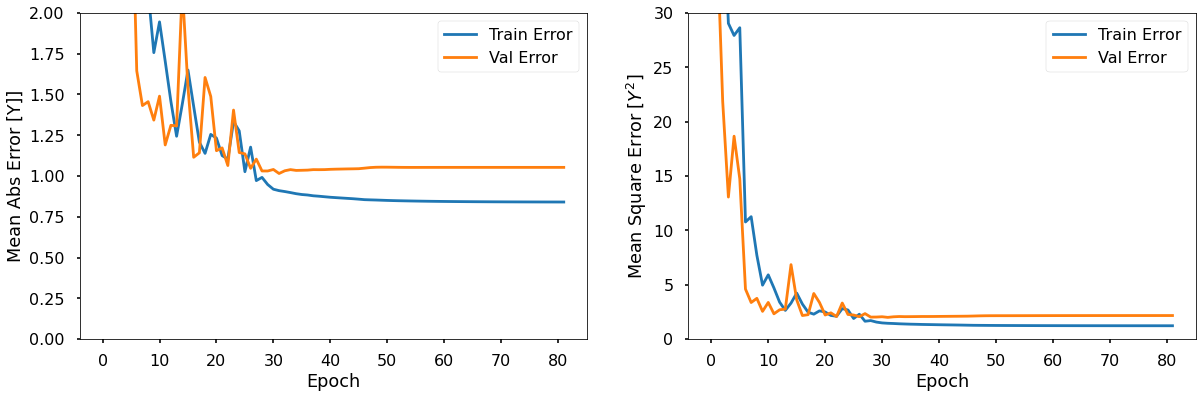

In [43]:
plot_history(history,(0, 2), (0,30))

In [0]:
# LSTM 레이어0 고정
simple_lstm_model.layers[0].trainable = False

In [0]:
# LSTM 레이어0를 제외한 레이어에 대해서 fine tuning 진행 (Transfer Learning)
finetune_history = simple_lstm_model.fit(
            sequence_finetune, target_finetune,
            epochs=epochs2,
            batch_size=batch_size2,
            validation_split=0.25,
            callbacks = [callback, callback_lr],
            shuffle=False, 
            verbose=0)

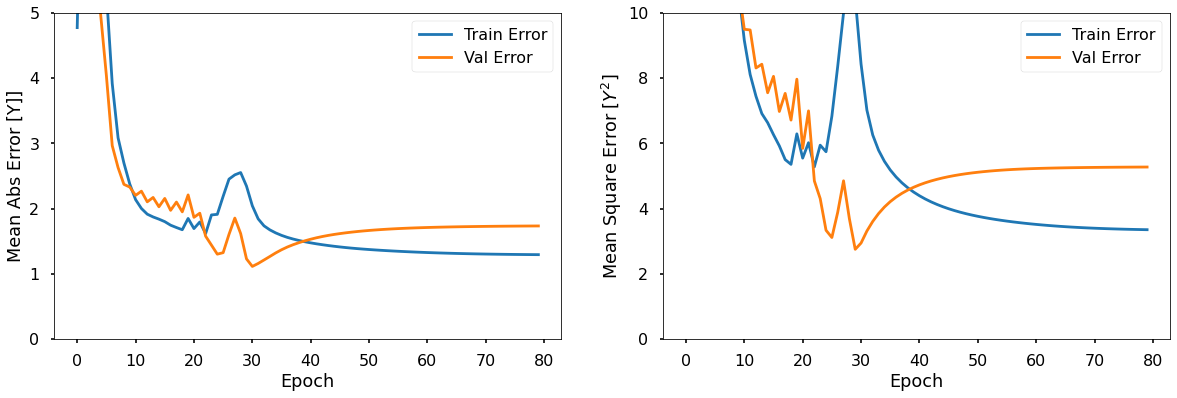

In [46]:
plot_history(finetune_history,(0, 5), (0,10))

In [0]:
# 예측하기 
test_predictions_lstm = simple_lstm_model.predict(test_sequence).flatten()

## model2 - LightGBM

### LightGBM 데이터 만들기

In [0]:
x_cols = feat_x_t

In [0]:
# 기본 적용
train_30_ = train_30[x_cols].copy()
train_3_ = train_3[x_cols].copy()
train_30_y_ = train_30_y.copy()
train_3_y_ = train_3_y.copy()
test_ = test[x_cols].copy()

In [0]:
epochs1 = 5000
epochs2 = 10000

In [0]:
m1_data = train_30_[x_cols]
m1 = int(len(m1_data)*0.9)
m1_train_data = lgb.Dataset(m1_data.iloc[:m1], label=train_30_y_.iloc[:m1])
m1_validation_data = lgb.Dataset(m1_data.iloc[m1:], label=train_30_y_.iloc[m1:])


m2_data = train_3_[x_cols]
m2 = int(len(m2_data)*0.8)
m2_train_data = lgb.Dataset(m2_data.iloc[:m2], label=train_3_y_.iloc[:m2])
m2_validation_data = lgb.Dataset(m2_data.iloc[m2:], label=train_3_y_.iloc[m2:])


### model

In [0]:
## model parameter
params ={'boosting_type': 'goss',
 'learning_rate': 0.0005,
 'num_leaves': 100,
 'random_state': 7,
 'objective': 'regression'}

In [53]:
model1 = lgb.train(params, 
            m1_train_data,
            valid_sets = m1_validation_data,
            verbose_eval=100,
            num_boost_round = epochs1, 
            early_stopping_rounds=10,
            keep_training_booster=True) 

Training until validation scores don't improve for 10 rounds.
[100]	valid_0's l2: 34.5193
[200]	valid_0's l2: 31.3779
[300]	valid_0's l2: 28.5486
[400]	valid_0's l2: 25.987
[500]	valid_0's l2: 23.6615
[600]	valid_0's l2: 21.5673
[700]	valid_0's l2: 19.6741
[800]	valid_0's l2: 17.9648
[900]	valid_0's l2: 16.4072
[1000]	valid_0's l2: 14.9975
[1100]	valid_0's l2: 13.7086
[1200]	valid_0's l2: 12.5388
[1300]	valid_0's l2: 11.5097
[1400]	valid_0's l2: 10.592
[1500]	valid_0's l2: 9.77163
[1600]	valid_0's l2: 9.01673
[1700]	valid_0's l2: 8.32757
[1800]	valid_0's l2: 7.71348
[1900]	valid_0's l2: 7.1556
[2000]	valid_0's l2: 6.63784
[2100]	valid_0's l2: 5.15672
[2200]	valid_0's l2: 4.2115
[2300]	valid_0's l2: 3.59381
[2400]	valid_0's l2: 3.1528
[2500]	valid_0's l2: 2.80996
[2600]	valid_0's l2: 2.55061
[2700]	valid_0's l2: 2.33891
[2800]	valid_0's l2: 2.16584
[2900]	valid_0's l2: 2.02275
[3000]	valid_0's l2: 1.89742
[3100]	valid_0's l2: 1.7948
[3200]	valid_0's l2: 1.70618
[3300]	valid_0's l2: 1.63

In [54]:
train_30[x_cols].shape

(4320, 43)

In [0]:
## model parameter
params ={'boosting_type': 'goss',
 'learning_rate': 0.0001,
 'num_leaves': 100,
 'random_state': 7,
 'objective': 'regression'}

In [56]:
## model parameter
model2 = lgb.train(params, 
            m2_train_data,
            valid_sets = m2_validation_data,
            verbose_eval = 100,
            early_stopping_rounds = 50,
            num_boost_round = epochs2, 
            init_model = model1) ## model1을 finetuning 

Training until validation scores don't improve for 50 rounds.
[4300]	valid_0's l2: 12.9267
[4400]	valid_0's l2: 12.7847
[4500]	valid_0's l2: 12.646
[4600]	valid_0's l2: 12.5117
[4700]	valid_0's l2: 12.3807
[4800]	valid_0's l2: 12.2527
[4900]	valid_0's l2: 12.1277
[5000]	valid_0's l2: 12.0057
[5100]	valid_0's l2: 11.8782
[5200]	valid_0's l2: 11.7482
[5300]	valid_0's l2: 11.6202
[5400]	valid_0's l2: 11.4952
[5500]	valid_0's l2: 11.371
[5600]	valid_0's l2: 11.2484
[5700]	valid_0's l2: 11.129
[5800]	valid_0's l2: 11.0123
[5900]	valid_0's l2: 10.8981
[6000]	valid_0's l2: 10.7863
[6100]	valid_0's l2: 10.6773
[6200]	valid_0's l2: 10.5706
[6300]	valid_0's l2: 10.4657
[6400]	valid_0's l2: 10.3632
[6500]	valid_0's l2: 10.2629
[6600]	valid_0's l2: 10.165
[6700]	valid_0's l2: 10.0724
[6800]	valid_0's l2: 9.9774
[6900]	valid_0's l2: 9.87669
[7000]	valid_0's l2: 9.77763
[7100]	valid_0's l2: 9.68095
[7200]	valid_0's l2: 9.58743
[7300]	valid_0's l2: 9.49541
[7400]	valid_0's l2: 9.40437
[7500]	valid_0'

In [0]:
test_predictions_lgbm = model2.predict(test_[x_cols], num_iteration=model2.best_iteration).flatten()

##model3 - XGBoost 

### XGBoost 데이터 만들기



In [0]:
#x_cols = ['time_diff', 'time_diff_2'] + feat_temp + feat_air_press + feat_rainfall + feat_sea_press + feat_insol + feat_humid

In [0]:
x_cols = feat_x_t

In [0]:
# 기본 적용
train_30_ = train_30[x_cols].copy()
train_3_ = train_3[x_cols].copy()
train_30_y_ = train_30_y.copy()
train_3_y_ = train_3_y.copy()
test_ = test[x_cols].copy()

In [0]:
data_dmatrix = xgb.DMatrix(data = pd.concat([train_30_, train_3_]),
                           label = pd.concat([train_30_y_, train_3_y_]))
train_dmatrix = xgb.DMatrix(data = train_30_,
                           label = train_30_y_)
val_dmatrix = xgb.DMatrix(data = train_3_,
                           label = train_3_y_)

### model

In [0]:
params_gen={
            'learning_rate':0.15,          # eta [default=0.3, alias: learning_rate]  **
            'min_split_loss':0,       # gamma [default=0, alias: min_split_loss] *
            'max_depth': 5,             # max_depth [default=6]  **
            'min_child_weight':3,         # min_child_weight [default=1] *
            'subsample':0.5,              # subsample [default=1] *
            'process_type':'default',     # process_type [default= default] Choices: default, update  *
}
params_lt={
            'objective': 'reg:squarederror', # reg:squarederror, reg:squaredlogerror, reg:logistic, reg:gamma, reg:tweedie
            'eval_metric':['rmse'],          # 'rmse', 'rmsle', 'mae', 'logloss'
            'seed': 202004,
}

In [0]:
params_gbtree ={'booster':'gbtree'}

In [0]:
params_gblinear ={'booster': 'gblinear',
                  'feature_selector': 'cyclic',   # feature_selector [default= cyclic], 'shuffle', 'random', 'greedy', 'thrifty'
}

In [0]:
params_dart ={'booster': 'dart', 
              'sample_type': 'uniform',         # sample_type [default= uniform] , 'weighted'
              'normalize_type': 'forest',         # normalize_type [default= tree] , 'forest'
              'rate_drop': 0.0,                 # rate_drop [default=0.0] , range: [0.0, 1.0]
              'one_drop': 0,                    # one_drop [default=0]  ...0,1 ? flag
              'skip_drop': 0.1                # skip_drop [default=0.0]  , range: [0.0, 1.0]
}

In [0]:
params = {**params_dart, **params_lt, **params_gen}

In [67]:
eval_sets = [(train_dmatrix, 'train'), (val_dmatrix, 'eval')]
xg_reg = xgb.train(params=params, dtrain=train_dmatrix, num_boost_round=3000,
                   evals=eval_sets, early_stopping_rounds=20,
                   verbose_eval=10)


[0]	train-rmse:19.7274	eval-rmse:23.1173
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 20 rounds.
[10]	train-rmse:4.06317	eval-rmse:5.96686
[20]	train-rmse:1.08503	eval-rmse:3.0019
[30]	train-rmse:0.644462	eval-rmse:2.5065
[40]	train-rmse:0.551067	eval-rmse:2.43762
[50]	train-rmse:0.502869	eval-rmse:2.42678
[60]	train-rmse:0.46126	eval-rmse:2.40545
[70]	train-rmse:0.429511	eval-rmse:2.40122
[80]	train-rmse:0.401913	eval-rmse:2.38799
[90]	train-rmse:0.378807	eval-rmse:2.3883
[100]	train-rmse:0.360701	eval-rmse:2.39095
Stopping. Best iteration:
[87]	train-rmse:0.383988	eval-rmse:2.3863



In [0]:
test_predictions_xgb = xg_reg.predict(data= xgb.DMatrix(data = test_[x_cols]),  ntree_limit=xg_reg.best_ntree_limit)

## prediction

In [0]:
test_predictions = (test_predictions_lgbm
                    +test_predictions_lstm
                    +test_predictions_xgb)/3
# 제출 파일 만들기
submit = pd.DataFrame({'id':range(144*33, 144*113),
              'Y18':test_predictions.reshape(1,-1)[0]})
now = datetime.now()
now =now.strftime('%m%d_%H%M')
submit.to_csv(os.path.join(project_path,'results', now +'_final.csv'), index = False)     